In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
from theano import tensor as tt
%matplotlib inline

In [2]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [3]:
K = 5 # Number of categories at which we truncate the dirichlet process
N = 10

In [4]:
samp_graph_t = np.concatenate([np.ones([3,3]),np.zeros([3,7])],axis=1)
samp_graph_b = np.concatenate([np.zeros([7,3]),np.ones([7,7])],axis=1)

samp_graph = np.concatenate([samp_graph_t,samp_graph_b])
samp_graph[3,2]=1
samp_graph[2,3]=1
samp_graph

array([[ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [ ]:
with pm.Model() as irm_model:
    gamma_ = pm.Gamma('gamma', 1., 1.)
    betas_crp = pm.Beta('betas_crp', 1., gamma_, shape=K)
    w = pm.Deterministic('w',stick_breaking(betas_crp))
    
    beta_ = pm.Gamma('beta_', 1., 1.)
    eta_ = pm.Beta('eta_',beta_,beta_, shape=[K,K])
    
    cat = tt.stack([pm.Multinomial('cat'+str(i),n=1,p=w, shape=K) for i in range(N)])
    
    link_prob = pm.math.dot(pm.math.dot(cat,eta_),tt.transpose(cat))
    R = pm.Bernoulli('R', p=link_prob, shape = [N,N],observed = samp_graph)

#     tau = pm.Gamma('tau', 1., 1., shape=K)
#     lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
#     mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
#     obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
#                            observed=old_faithful_df.std_waiting.values)

In [ ]:
with pm.Model() as irm_model:
    gamma_ = pm.Gamma('gamma', 1., 1.)
    betas_crp = pm.Beta('betas_crp', 1., gamma_, shape=K)
    w = pm.Deterministic('w',stick_breaking(betas_crp))
    
    beta_ = pm.Gamma('beta_', 1., 1.)
    eta_ = pm.Beta('eta_',beta_,beta_, shape=[K,K])
    
    cat_x = pm.Categorical('cat_x',p=w,shape=N)
    cat_y = pm.Categorical('cat_y',p=w,shape=N)
    
    link_prob = eta_[cat_x,cat_y]
    R = pm.Bernoulli('R', p=link_prob,observed = samp_graph)

In [ ]:
pm.Dirichlet?

In [20]:
with pm.Model() as irm_model:
    w = pm.Dirichlet('w',a=np.array([1.,1.]))
    
    beta_ = pm.Gamma('beta_', 1., 1.)
    eta_ = pm.Beta('eta_',beta_,beta_, shape=[2,2])
    
    cat = tt.stack([pm.Multinomial('cat'+str(i),n=1,p=w, shape=2) for i in range(N)])
    
    link_prob = pm.math.dot(pm.math.dot(cat,eta_),tt.transpose(cat))
    R = pm.Bernoulli('R', p=link_prob, shape = [N,N],observed = samp_graph)

In [15]:
with pm.Model() as irm_model:
    #w = pm.Dirichlet('w',a=np.array([3.,7.]))
    gamma_ = pm.Gamma('gamma', 1., 1.)
    betas_crp = pm.Beta('betas_crp', 1., gamma_, shape=K)
    w = pm.Deterministic('w',stick_breaking(betas_crp))
    
    cat = pm.Categorical('cat',p=w,shape=N)
    
    beta_ = pm.Gamma('beta_', 1., 1.)
    eta_ = pm.Beta('eta_',beta_,beta_, shape=[K,K])
    
    
    Rs=[]
    for i in range(N):
        for j in range(N):
            Rs.append(pm.Bernoulli('R'+str(i)+','+str(j),p=eta_[cat[i],cat[j]],observed = samp_graph[i,j]))
    

In [9]:
with irm_model:
    map_est = pm.find_MAP()

Optimization terminated successfully.
         Current function value: 75.272977
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10


In [10]:
print(map_est)

{'eta__logodds_': array([[ 0.        ,  0.        ],
       [ 0.        ,  0.38155568]]), 'beta__log_': array(1.1155918179602569), 'w_stickbreaking_': array([-1.73460042]), 'cat': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


In [ ]:
print(map_est)

print('\n')
print(1./(1+np.exp(-map_est['betas_crp_logodds_'])))

for i in range(10):
    print('cat'+str(i)+': '+str(map_est['cat'+str(i)]))

In [16]:
with irm_model:
    trace = pm.sample(500, n_init=500)

Assigned NUTS to gamma_log_
Assigned NUTS to betas_crp_logodds_
Assigned CategoricalGibbsMetropolis to cat
Assigned NUTS to beta__log_
Assigned NUTS to eta__logodds_
INFO (theano.gof.compilelock): Refreshing lock /Users/libland/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/libland/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/libland/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/libland/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


In [23]:
trace.varnames

['gamma_log_',
 'betas_crp_logodds_',
 'cat',
 'beta__log_',
 'eta__logodds_',
 'gamma',
 'betas_crp',
 'w',
 'beta_',
 'eta_']

In [27]:
trace['cat'][-20:]

array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])

In [35]:
np.mean(1./(1.+np.exp(-trace['eta__logodds_'][-2:])),axis=0)

array([[  9.99934167e-01,   5.35075501e-02,   7.32808041e-04,
          2.44144472e-01,   5.06163973e-01],
       [  2.55485719e-02,   9.92845179e-01,   2.45040433e-03,
          3.91896637e-01,   2.74019731e-01],
       [  5.04214390e-01,   5.13354873e-01,   1.10895503e-01,
          9.87729312e-01,   5.72126301e-01],
       [  7.89100816e-02,   5.04506791e-01,   5.21470816e-01,
          6.46654373e-01,   4.09795585e-03],
       [  5.44204170e-01,   4.99910066e-01,   2.40135537e-02,
          6.47285093e-01,   3.93417770e-01]])

In [24]:
pm.traceplot(trace['cat'])

AttributeError: 'numpy.ndarray' object has no attribute 'varnames'

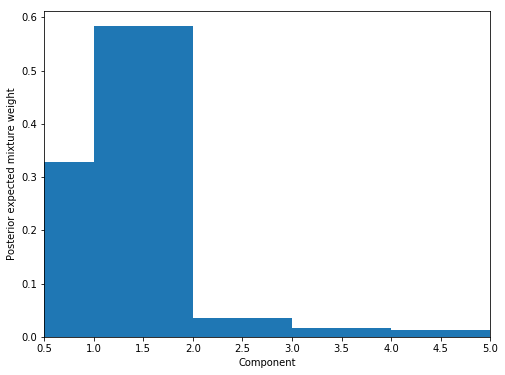

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [ ]:

x_plot = np.linspace(-3, 3, 200)
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True,
        color='blue', lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True,
        color='blue', lw=0, alpha=0.5);

ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);


In [22]:
test_data = np.array([1,1,1,0,0,1,2,2,2,1])

In [23]:
with pm.Model() as crp_model:
    gamma_ = pm.Gamma('gamma', 1., 1.)
    betas_crp = pm.Beta('betas_crp', 1., gamma_, shape=K)
    w = pm.Deterministic('w',stick_breaking(betas_crp))
    
    obs = pm.Categorical('obs',p=w,observed = test_data)

In [24]:
map_est = pm.find_MAP(model=crp_model)

Optimization terminated successfully.
         Current function value: 19.288660
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12


In [25]:
print(map_est)

{'betas_crp_logodds_': array([-1.23005165,  0.13082556,  0.56906068, -0.8172319 , -0.8172319 ]), 'gamma_log_': array(0.46566454286454245)}


In [ ]:
np.tile(samp_graph,(2,1,1))